In [1]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

/Users/lachezargeorgiev/opt/anaconda3/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/Users/lachezargeorgiev/opt/anaconda3/lib/python3.8/site-packages/qiskit/chemistry/__init__.py:170: DeprecationWarning: The package qiskit.chemistry is deprecated. It was moved/refactored to qiskit_nature (pip install qiskit-nature). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('chemistry', 'qiskit_nature', 'qiskit-nature')


In [2]:
def get_qubit_op(dist):
    driver = PySCFDriver(atom="Li .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    freeze_list = [0]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    shift = energy_shift + repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

In [3]:
backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(result.eigenvalues) + shift)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    ) 
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    
print("All energies have been calculated")

/Users/lachezargeorgiev/opt/anaconda3/lib/python3.8/site-packages/qiskit/aqua/components/optimizers/optimizer.py:49: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.components.optimizers',
/Users/lachezargeorgiev/opt/anaconda3/lib/python3.8/site-packages/qiskit/chemistry/fermionic_operator.py:386: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  pauli_list = WeightedPauliOperator(paulis=[])
/Users/lachezargeorgiev/opt/anaconda3/lib/python3.8/site-packages/qiskit/chemistry/fermionic_operator.py:394: DeprecationWarning: The variable qiskit.aqua.aqua_globals is depr

Interatomic Distance: 0.5 VQE Result: -7.0396734414021 Exact Energy: [-7.03973252]


/Users/lachezargeorgiev/opt/anaconda3/lib/python3.8/site-packages/qiskit/chemistry/components/initial_states/hartree_fock.py:61: DeprecationWarning: The HartreeFock class is deprecated as of Aqua 0.9 and will be removed no earlier than 3 months after the release date. Instead, all algorithms and circuits accept a plain QuantumCircuit. 
  super().__init__()


Interatomic Distance: 0.6 VQE Result: -7.313308880237252 Exact Energy: [-7.31334583]
Interatomic Distance: 0.7 VQE Result: -7.500887034288281 Exact Energy: [-7.50092209]
Interatomic Distance: 0.8 VQE Result: -7.630945409708084 Exact Energy: [-7.63097825]
Interatomic Distance: 0.9 VQE Result: -7.720781099480281 Exact Energy: [-7.72081241]
Interatomic Distance: 1.0 VQE Result: -7.782211599132944 Exact Energy: [-7.7822424]
Interatomic Distance: 1.1 VQE Result: -7.823568081702103 Exact Energy: [-7.82359928]
Interatomic Distance: 1.2 VQE Result: -7.8506661316083886 Exact Energy: [-7.85069838]
Interatomic Distance: 1.3 VQE Result: -7.86752958602734 Exact Energy: [-7.86756329]
Interatomic Distance: 1.4 VQE Result: -7.876966253547472 Exact Energy: [-7.87700149]
Interatomic Distance: 1.5 VQE Result: -7.880979505772888 Exact Energy: [-7.88101572]
Interatomic Distance: 1.6 VQE Result: -7.881036616614853 Exact Energy: [-7.88107204]
Interatomic Distance: 1.7 VQE Result: -7.878236971173694 Exact Ene

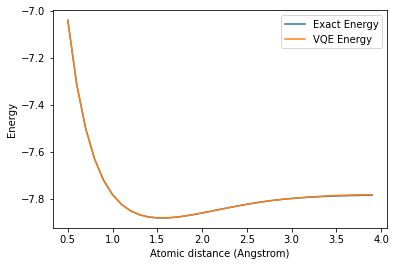

In [4]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()